In [82]:
import torch
from torch import nn
from torch.nn import functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc21 = nn.Linear(512, latent_dim)  # Mean
        self.fc22 = nn.Linear(512, latent_dim)  # Log variance

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))  # Assuming input_dim is 784 for an MNIST image
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [126]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision import datasets, transforms

class NoisyMNISTDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        clean_image, label = self.mnist_dataset.dataset[idx]

        # Add Gaussian noise
        noise = 0.5*torch.randn_like(clean_image)
        noisy_image = clean_image + noise

        return noisy_image, clean_image  # Return the noisy image and the original as the target

# Load the dataset
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x + 0.5*torch.randn_like(x)  # Adding Gaussian noise
])

train_dataset = MNIST(root='./data', train=True, transform=mnist_transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [84]:
# Adjusted Loss Function with MSE
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')  # Assuming input_dim is 784

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD


In [86]:
# Model, Optimizer, and Loss Function
model = VAE(input_dim=784, latent_dim=20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Check if a GPU is available and use it; otherwise, fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)

# Adjusted Training Loop
for epoch in range(10):  # Train for 10 epochs
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # If using a GPU, ensure data and model are on the same device
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')



Epoch 0, Loss: 237.67575049641928
Epoch 1, Loss: 229.71613195800782
Epoch 2, Loss: 228.3692053141276
Epoch 3, Loss: 227.77554576009115
Epoch 4, Loss: 227.44813501790364
Epoch 5, Loss: 227.02819916178385
Epoch 6, Loss: 226.79462249348958
Epoch 7, Loss: 226.67807062988282
Epoch 8, Loss: 226.4928719563802
Epoch 9, Loss: 226.3050887125651


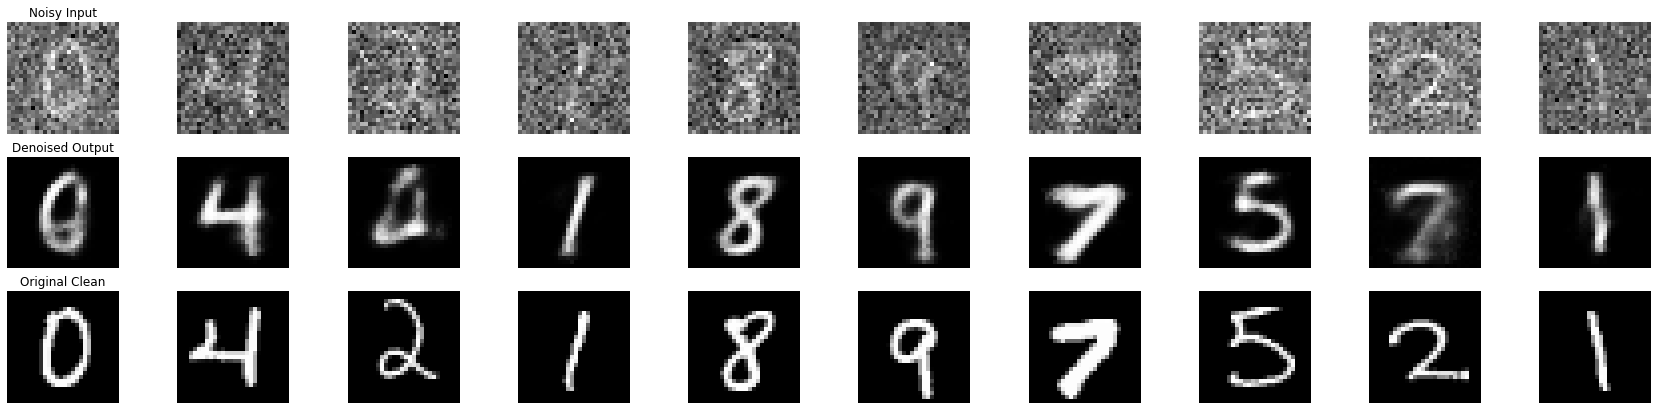

In [134]:
test_dataset = datasets.MNIST(
  root = 'data', 
  train = False, 
  transform = ToTensor()
  )
# Create a noisy test dataset
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=64)
noisy_test_dataset = NoisyMNISTDataset(test_data)
test_loader = DataLoader(noisy_test_dataset, batch_size=64, shuffle=True)

def visualize_denoising(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        for noisy_images, clean_images in test_loader:
            outputs, mu, logvar = model(noisy_images)  # Get model predictions
            # Convert the first 10 images in the batch from PyTorch tensors to NumPy arrays
            noisy_images = noisy_images[:10].numpy()
            clean_images = clean_images[:10].numpy()
            outputs = outputs[:10].numpy()

            # Plotting
            fig, axes = plt.subplots(3, 10, figsize=(30, 7))
            for i in range(10):
                # Noisy images
                ax = axes[0, i]
                ax.imshow(noisy_images[i].squeeze(), cmap='gray')
                ax.axis('off')
                if i == 0:
                    ax.set_title('Noisy Input')
                
                # Denoised images (model output)
                ax = axes[1, i]
                ax.imshow(outputs[i].reshape([28,28]).squeeze(), cmap='gray')
                ax.axis('off')
                if i == 0:
                    ax.set_title('Denoised Output')
                
                # Original clean images
                ax = axes[2, i]
                ax.imshow(clean_images[i].squeeze(), cmap='gray')
                ax.axis('off')
                if i == 0:
                    ax.set_title('Original Clean')

            plt.show()
            break  # Only show the first batch

# Assuming `model` is your trained model and `test_loader` is your noisy test dataset loader
visualize_denoising(model, test_loader)

In [144]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 20)  # Assuming latent space of size 10 (for mean and log variance)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Ensure output is between 0 and 1
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return h1[:, :10], h1[:, 10:]  # Split the result into mean and log variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [136]:
def loss_function(recon_x, x, mu, logvar):
    # Adjust MSE calculation for image data
    MSE = F.mse_loss(recon_x, x, reduction='sum')

    # KL Divergence remains the same
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD


In [145]:
# Model, Optimizer, and Loss Function
model = ConvVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Check if a GPU is available and use it; otherwise, fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)

# Adjusted Training Loop
for epoch in range(10):  # Train for 10 epochs
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # If using a GPU, ensure data and model are on the same device
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

KeyboardInterrupt: 

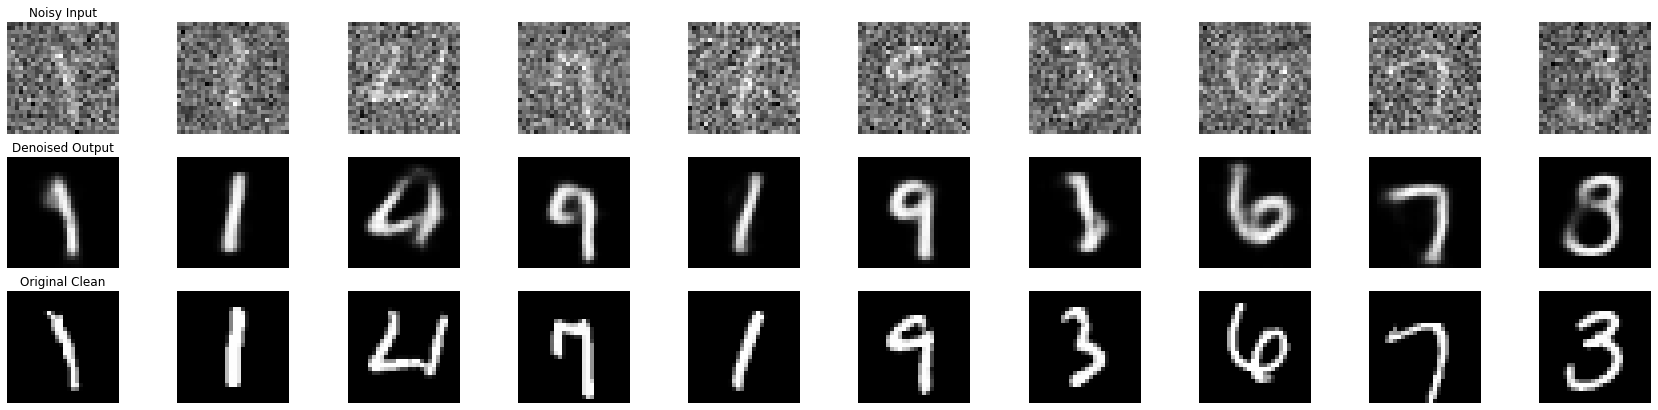

In [138]:
# You can omit 'original_images' if you don't have the clean images
visualize_denoising(model, test_loader)


### `What about sound samples?`
I am using two datasets from Kaggle:

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
https://www.kaggle.com/datasets/minsithu/audio-noise-dataset?resource=download

In [33]:
import torch
from torch import nn

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3_mu = nn.Linear(256, latent_dim)
        self.fc3_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3_mu(h), self.fc3_logvar(h)  # Returns mean and log variance

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return torch.sigmoid(self.fc3(h))  # Using sigmoid to ensure output is between 0 and 1

class AudioVAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AudioVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x.view(-1, 22050))  # Assuming x is [batch_size, 22050]
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar



In [76]:
import os
import numpy as np
import librosa
import torch
from torch.utils.data import Dataset, DataLoader

def split_audio_into_chunks(file_path, filename, samples_per_chunk=44100, sr=None):
    full_path = os.path.join(file_path, filename)
    audio, sample_rate = librosa.load(full_path, sr=sr)
    noise = np.random.normal(0, 0.001, audio.shape)
    noisy_audio = np.clip(audio + noise, -1, 1)
    total_chunks = int(np.ceil(len(audio) / samples_per_chunk))
    train_data = [[], []]
    
    for i in range(total_chunks):
        start_sample = i * samples_per_chunk
        end_sample = start_sample + samples_per_chunk
        chunk = audio[start_sample:end_sample]
        chunk_noisy = noisy_audio[start_sample:end_sample]
        
        # Padding if necessary
        if len(chunk) < samples_per_chunk:
            padding = samples_per_chunk - len(chunk)
            chunk = np.pad(chunk, (0, padding), 'constant', constant_values=(0, 0))
            chunk_noisy = np.pad(chunk_noisy, (0, padding), 'constant', constant_values=(0, 0))
            
        train_data[0].append(chunk)
        train_data[1].append(chunk_noisy)
    
    return train_data

class AudioChunkDataset(Dataset):
    def __init__(self, train_data, transform=None):
        self.clean_audio_chunks = train_data[0]
        self.noisy_audio_chunks = train_data[1]
        self.transform = transform

    def __len__(self):
        return len(self.clean_audio_chunks)

    def __getitem__(self, idx):
        clean_chunk = self.clean_audio_chunks[idx]
        noisy_chunk = self.noisy_audio_chunks[idx]
        
        clean_chunk = torch.tensor(clean_chunk, dtype=torch.float32).unsqueeze(0)  # Adding channel dimension
        noisy_chunk = torch.tensor(noisy_chunk, dtype=torch.float32).unsqueeze(0)  # Adding channel dimension
        
        if self.transform:
            clean_chunk = self.transform(clean_chunk)
            noisy_chunk = self.transform(noisy_chunk)

        return noisy_chunk, clean_chunk

# Example usage
file_path = "..\\data\\GTZAN\\GTZAN_Samples\\Data\\genres_original\\classical\\"
train_d = split_audio_into_chunks(file_path, "classical.00001.wav", sr=22050)
for filename in os.listdir(file_path):
    train_d = np.concatenate((train_d, split_audio_into_chunks(file_path, filename, sr=22050)), axis=1)

audio_dataset = AudioChunkDataset(train_d)
dataloader = DataLoader(audio_dataset, batch_size=50, shuffle=True)


In [71]:
print(len(train_d[0][0]))

22050


In [78]:
# Parameters
input_dim = 22050
latent_dim = 64  # Or any other size you wish to try
# Model, Optimizer, and Loss Function
model = AudioVAE(input_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Check if a GPU is available and use it; otherwise, fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)

epochs = 10

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):  # Assuming train_loader is defined
        data = data.to(device)  # Assuming device is defined
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        #if batch_idx % log_interval == 0:  # log_interval is defined elsewhere
        #    print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item() / len(data)}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset)}')
for epoch in range(1, epochs + 1):
     train(epoch)

C:\Users\LINRY~1.PRE\AppData\Local\Temp/ipykernel_28500/217074976.py:3: UserWarning: Using a target size (torch.Size([50, 1, 22050])) that is different to the input size (torch.Size([50, 22050])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  MSE = F.mse_loss(recon_x, x, reduction='sum')
C:\Users\LINRY~1.PRE\AppData\Local\Temp/ipykernel_28500/217074976.py:3: UserWarning: Using a target size (torch.Size([29, 1, 22050])) that is different to the input size (torch.Size([29, 22050])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  MSE = F.mse_loss(recon_x, x, reduction='sum')


====> Epoch: 1 Average loss: 28195511.198987797
====> Epoch: 2 Average loss: 7214.807216762544
====> Epoch: 3 Average loss: 4136.571218839885
====> Epoch: 4 Average loss: 4134.487065306408
====> Epoch: 5 Average loss: 4131.101699824225
====> Epoch: 6 Average loss: 4131.469176953499
====> Epoch: 7 Average loss: 4122.017110598434
====> Epoch: 8 Average loss: 4133.716832454458
====> Epoch: 9 Average loss: 4134.817074145094
====> Epoch: 10 Average loss: 4128.219432875919


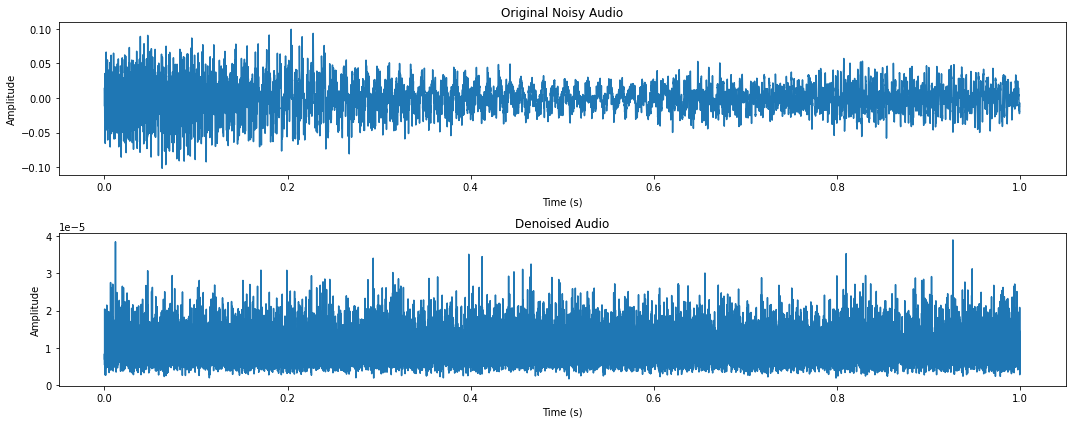

Original Noisy Audio:


Original Audio:


Denoised Audio:


In [77]:
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio

# Assuming `noisy_audio` is your input audio array sampled at 22,050 Hz
# Make sure `noisy_audio` is a numpy array with shape [22050,] for 1 second of audio

# Normalize and convert your noisy_audio to a tensor
noisy_audio_tensor = torch.FloatTensor(train_d[1][0]).view(1, -1)  # Add batch dimension

# Pass the noisy audio through the model to get the denoised version
model.eval()  # Ensure model is in evaluation mode
with torch.no_grad():
    reconstructed_audio, _, _ = model(noisy_audio_tensor)
    denoised_audio = reconstructed_audio.view(-1).cpu().numpy()  # Remove batch dimension and convert to numpy

# Sampling rate
sr = 22050

# Plotting
plt.figure(figsize=(15, 6))

# Original Noisy Audio
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, 1, len(train_d[1][0])), train_d[1][0])
plt.title('Original Noisy Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Denoised Audio
plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, 1, len(denoised_audio)), denoised_audio)
plt.title('Denoised Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Listen to the Original Noisy Audio
print("Original Noisy Audio:")
display(Audio(train_d[1][0], rate=sr))

# Listen to the original Audio
print("Original Audio:")
display(Audio(train_d[0][0], rate=sr))

# Listen to the Denoised Audio
print("Denoised Audio:")
display(Audio(denoised_audio, rate=sr))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def fft_on_chunks(audio, chunk_size=1024):
    """
    Perform FFT on audio chunks and return the average magnitude spectrum.
    
    Parameters:
    - audio: The audio signal array.
    - chunk_size: Size of each chunk for FFT.
    
    Returns:
    - freqs: Frequencies corresponding to the magnitude spectrum.
    - avg_magnitude: Average magnitude spectrum of the chunks.
    """
    # Number of chunks
    num_chunks = len(audio) // chunk_size
    
    # Initialize the sum of magnitude spectra
    magnitude_sum = np.zeros(chunk_size // 2 + 1)
    
    # Process each chunk
    for i in range(num_chunks):
        # Extract the chunk
        chunk = audio[i*chunk_size:(i+1)*chunk_size]
        
        # Apply FFT
        fft_result = np.fft.rfft(chunk)
        
        # Compute magnitude
        magnitude = np.abs(fft_result)
        
        # Accumulate the magnitude
        magnitude_sum += magnitude
        
    # Compute average magnitude spectrum
    avg_magnitude = magnitude_sum / num_chunks
    
    # Frequency axis
    freqs = np.fft.rfftfreq(chunk_size, d=1./22050)
    
    return freqs, avg_magnitude

# Assuming `noisy_audio` and `denoised_audio` are your input and output arrays
chunk_size = 2048  # Example chunk size, can be adjusted

# Compute average magnitude spectrum for noisy and denoised audio
freqs_noisy, avg_magnitude_noisy = fft_on_chunks(noisy_audio, chunk_size=chunk_size)
freqs_denoised, avg_magnitude_denoised = fft_on_chunks(denoised_audio, chunk_size=chunk_size)

# Plotting
plt.figure(figsize=(14, 6))

# Noisy Audio Spectrum
plt.subplot(1, 2, 1)
plt.plot(freqs_noisy, avg_magnitude_noisy)
plt.title('Average Magnitude Spectrum (Noisy)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

# Denoised Audio Spectrum
plt.subplot(1, 2, 2)
plt.plot(freqs_denoised, avg_magnitude_denoised)
plt.title('Average Magnitude Spectrum (Denoised)')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()
